In [3]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from scipy.stats import linregress
import nibabel as nib
import urllib
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
from __future__ import division

In [4]:
behav_data_f = '../../Phenotypic_V1_0b_preprocessed1.csv'
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])

In [11]:
def split_two_matched_samples(df, motion_thresh, age_l, age_u, n):
    """
    This function takes in a data frame, thresholds it to only include
    participants whose percentage bad frames are less than motion_thresh
    and participants who are between the lower and upper age limits (inclusive),
    then returns two matched samples of size n. The samples are matched on
    age in years, autism diagnosis, gender and scanning site. This function also selectively samples the
    func_perc_fd
    Information about the motion measure is here:
    http://preprocessed-connectomes-project.org/quality-assessment-protocol/
    """
    
    # Start by removing all participants whose data is below a certain
    # motion threshold.
    df_samp_motion =  df.loc[df['func_perc_fd'] < motion_thresh, :]

    # Then remove participants who are younger (in years) than age_l and older
    # than age_u. Note that this means people who are age_l and age_u
    # (eg 6 and 10) will be included in the sample.
    df_samp = df_samp_motion.loc[(df_samp_motion['AGE_YRS']>=age_l)
                                    & (df_samp_motion['AGE_YRS']<=age_u), :]
                                    
    ##sort subjects based on motion
    sort_column_list = ['func_perc_fd']
    df_motion_sorted = df_samp.sort_values(by=sort_column_list)
    
    ##rank subjects by motion
    r=range(len(df_motion_sorted))
    r_df=pd.DataFrame(r)
    r_df.columns = ['rank']
    r_df['newcol'] = df_motion_sorted.index
    r_df.set_index('newcol', inplace=True)
    r_df.index.names = [None]
    df_motion_sorted_rank=pd.concat ([r_df,df_motion_sorted], axis=1)
    
    ##create bins of subjects in quartiles
    l=len(df_motion_sorted_rank)
    chunk=l/4
    chunk1=chunk
    chunk2=2*chunk
    chunk3=3*chunk
    chunk4=l
    
    first=df_motion_sorted_rank[df_motion_sorted_rank['rank']<=chunk1]
    second=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk1) & (df_motion_sorted_rank['rank']<=chunk2)]
    third=df_motion_sorted_rank[(df_motion_sorted_rank['rank']>chunk2) & (df_motion_sorted_rank['rank']<=chunk3)]
    fourth=df_motion_sorted_rank[df_motion_sorted_rank['rank']>=chunk3]
    
    ##take 2n/4 from each bin
    n_samp=(n*2)/4
    n_samp
    n_samp=int(n_samp)

    # Shuffle these remaining participants to ensure you get different sub
    # samples each time you run the code.
    first_rand = first.reindex(np.random.permutation(first.index))
    second_rand = second.reindex(np.random.permutation(second.index))
    third_rand = third.reindex(np.random.permutation(third.index))
    fourth_rand = fourth.reindex(np.random.permutation(fourth.index))

    # Only keep the top 2*n/4 participants.
    first_samp_2n = first_rand.iloc[:n_samp, :]
    second_samp_2n = second_rand.iloc[:n_samp, :]
    third_samp_2n = third_rand.iloc[:n_samp, :]
    fourth_samp_2n = fourth_rand.iloc[:n_samp, :]
    
    #append these together
    frames = [first_samp_2n, second_samp_2n, third_samp_2n,fourth_samp_2n]
    final_df = pd.concat(frames)

    # Sort these participants according to the sort columns of interest
    sort_column_list = ['DSM_IV_TR', 'DX_GROUP', 'SITE_ID', 'SEX', 'AGE_YRS']
    df_samp_2n_sorted = final_df.sort_values(by=sort_column_list)

    # Now put all even numbered participants in group A and all odd numbered
    # participants in group B.
    df_grp_A = df_samp_2n_sorted.iloc[::2, :]
    df_grp_B = df_samp_2n_sorted.iloc[1::2, :]

    # Boom! Return these two data frames
    return df_grp_A, df_grp_B


In [10]:
df_A, df_B = split_two_matched_samples(df, 50, 6, 18, 100)
print df_A[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()
print df_B[['AGE_AT_SCAN', 'DX_GROUP', 'SEX']].describe()

       AGE_AT_SCAN  DX_GROUP         SEX
count   100.000000    100.00  100.000000
mean     13.137511      1.55    1.100000
std       2.972148      0.50    0.301511
min       7.150000      1.00    1.000000
25%      11.000000      1.00    1.000000
50%      13.491500      2.00    1.000000
75%      15.507500      2.00    1.000000
max      18.700000      2.00    2.000000
       AGE_AT_SCAN    DX_GROUP         SEX
count   100.000000  100.000000  100.000000
mean     13.124667    1.560000    1.170000
std       2.752681    0.498888    0.377525
min       7.290000    1.000000    1.000000
25%      11.231725    1.000000    1.000000
50%      13.200000    2.000000    1.000000
75%      15.028975    2.000000    1.000000
max      18.900000    2.000000    2.000000


In [12]:
def make_group_corr_mat(df):
    """
    This function reads in each subject's aal roi time series files and creates roi-roi correlation matrices
    for each subject and then sums them all together. The final output is a 3d matrix of all subjects 
    roi-roi correlations, a mean roi-roi correlation matrix and a roi-roi covariance matrix. 
    **NOTE WELL** This returns correlations transformed by the Fisher z, aka arctanh, function.    
    """

    # for each subject do the following
    
    for i, (sub, f_id) in enumerate(df[['SUB_ID', 'FILE_ID']].values):
        
        #read each subjects aal roi time series files
        ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

        #create a correlation matrix from the roi all time series files
        corr_mat_r = ts_df.corr()
        #the correlations need to be transformed to Fisher z, which is
        #equivalent to the arctanh function.
        corr_mat_z = np.arctanh(corr_mat_r)
        
        #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
        if i == 0:
            all_corr_mat = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], len(df)])

        #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
        all_corr_mat[:, :, i] = corr_mat_z
    
    #create the mean correlation matrix (ignore nas - sometime there are some...)
    av_corr_mat = np.nanmean(all_corr_mat, axis=2)
    #create the group covariance matrix (ignore nas - sometime there are some...)
    std_corr_mat = np.nanstd(all_corr_mat, axis=2)
        
    return all_corr_mat, av_corr_mat, std_corr_mat


In [13]:
all_corr_mat_A, av_corr_mat_A, std_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, std_corr_mat_B = make_group_corr_mat(df_B)

/om/user/jlnrd/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in arctanh


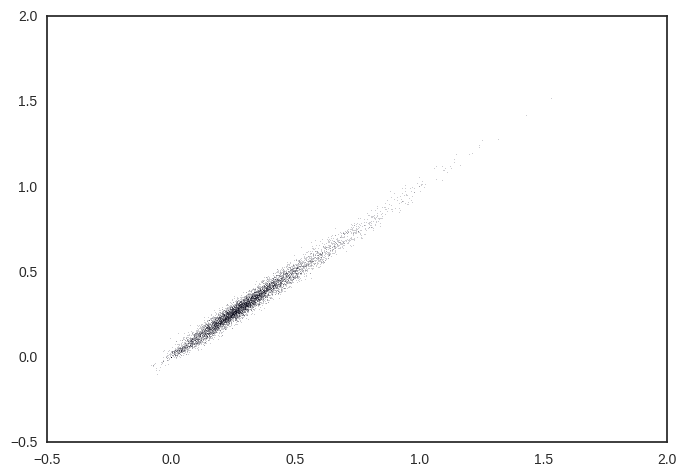

In [19]:
plt.scatter(np.triu(av_corr_mat_A, k=1).reshape(-1), np.triu(av_corr_mat_B, k=1).reshape(-1), s=0.01)

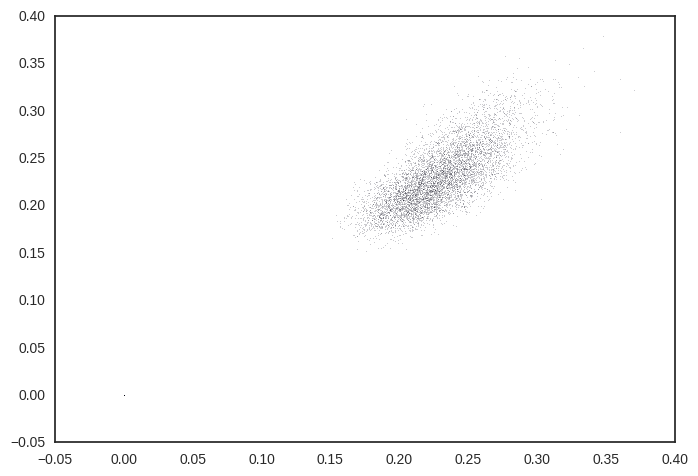

In [18]:
plt.scatter(np.triu(std_corr_mat_A, k=1).reshape(-1), np.triu(std_corr_mat_B, k=1).reshape(-1), s=0.01)

In [20]:

def calc_rsq(std_corr_mat_A, std_corr_mat_B):
    """
    From wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    Rsq = 1 - (SSres / SStot)
    
    SSres is calculated as the sum of square errors (where the error
    is the difference between x and y).
    
    SStot is calculated as the total sum of squares in y.
    """
    # Get the data we need
    inds = np.triu_indices_from(std_corr_mat_B, k=1)
    x = std_corr_mat_A[inds]
    y = std_corr_mat_B[inds]
    
    # Calculate the error/residuals
    res = y - x

    SSres = np.sum(res**2)
    
    # Sum up the total error in y
    y_var = y - np.mean(y)
    
    SStot = np.sum(y_var**2)
    
    # R squared
    Rsq = 1 - (SSres/SStot)
    
    return Rsq

In [22]:
Rsq = calc_rsq(std_corr_mat_A, std_corr_mat_B)
Rsq

0.52408175382469679

In [25]:
df_A, df_B = split_two_matched_samples(df, 50, 6, 18, 20)
all_corr_mat_A, av_corr_mat_A, std_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, std_corr_mat_B = make_group_corr_mat(df_B)
Rsq = calc_rsq(std_corr_mat_A, std_corr_mat_B)
Rsq

/om/user/jlnrd/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in arctanh


-0.68129874030078685

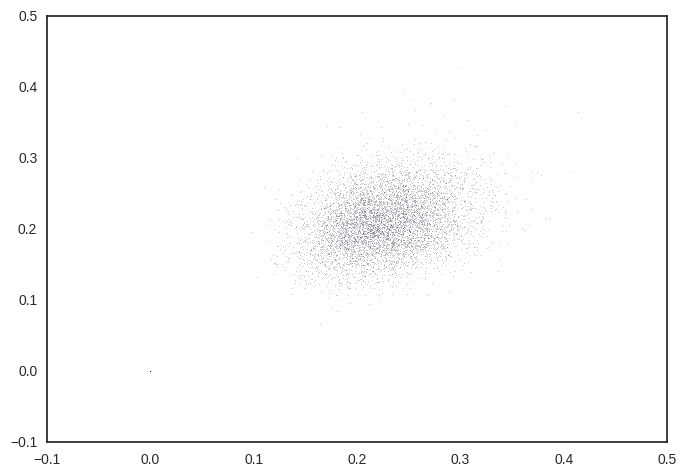

In [24]:
plt.scatter(np.triu(std_corr_mat_A, k=1).reshape(-1), np.triu(std_corr_mat_B, k=1).reshape(-1), s=0.01)

In [26]:
df_A, df_B = split_two_matched_samples(df, 10, 6, 18, 20)
all_corr_mat_A, av_corr_mat_A, std_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, std_corr_mat_B = make_group_corr_mat(df_B)
Rsq = calc_rsq(std_corr_mat_A, std_corr_mat_B)
Rsq

/om/user/jlnrd/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in arctanh


-0.77147153980319283

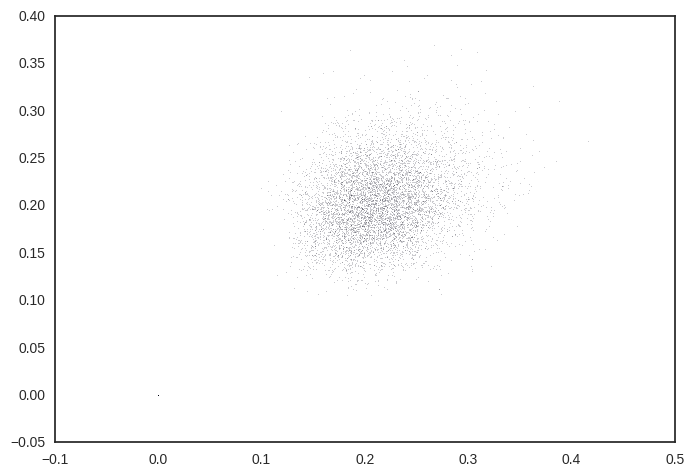

In [27]:
plt.scatter(np.triu(std_corr_mat_A, k=1).reshape(-1), np.triu(std_corr_mat_B, k=1).reshape(-1), s=0.01)

In [28]:
df_A, df_B = split_two_matched_samples(df, 50, 6, 18, 100)
all_corr_mat_A, av_corr_mat_A, std_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, std_corr_mat_B = make_group_corr_mat(df_B)
Rsq = calc_rsq(std_corr_mat_A, std_corr_mat_B)
Rsq

/om/user/jlnrd/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in arctanh


0.22365589813686393

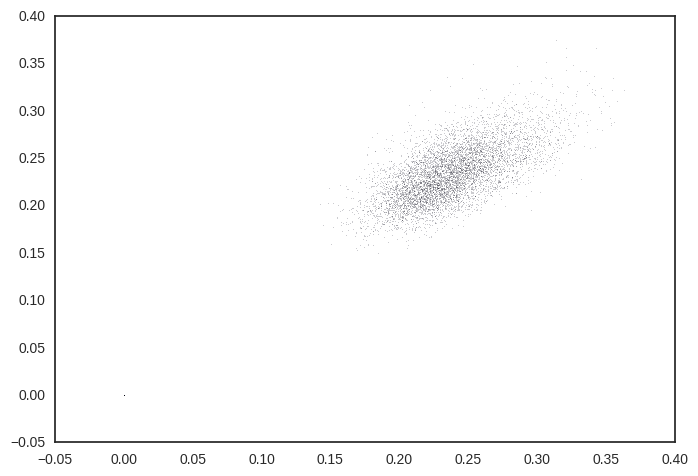

In [29]:
plt.scatter(np.triu(std_corr_mat_A, k=1).reshape(-1), np.triu(std_corr_mat_B, k=1).reshape(-1), s=0.01)

In [30]:
df_A, df_B = split_two_matched_samples(df, 10, 6, 18, 100)
all_corr_mat_A, av_corr_mat_A, std_corr_mat_A = make_group_corr_mat(df_A)
all_corr_mat_B, av_corr_mat_B, std_corr_mat_B = make_group_corr_mat(df_B)
Rsq = calc_rsq(std_corr_mat_A, std_corr_mat_B)
Rsq

/om/user/jlnrd/py27/lib/python2.7/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in arctanh


0.21925351197480358

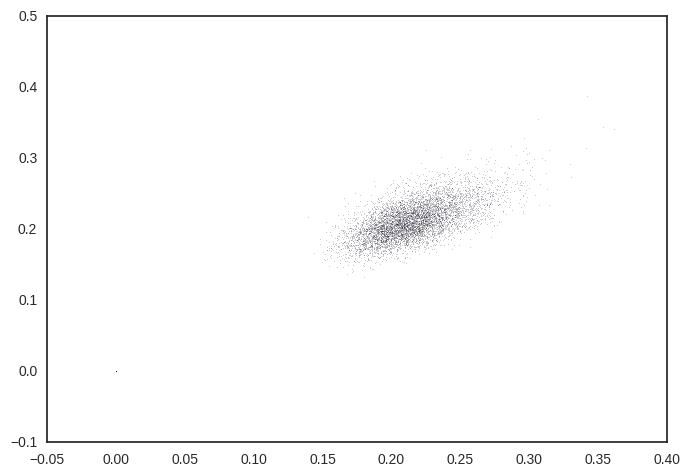

In [31]:
plt.scatter(np.triu(std_corr_mat_A, k=1).reshape(-1), np.triu(std_corr_mat_B, k=1).reshape(-1), s=0.01)